In [ ]:
!pip install tensorflow pandas matplotlib keras graphviz

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Config ---

In [ ]:
DATA_DIR = "data/labeled_chunks_8"
SEQ_LENGTH = 8
N_FEATURES = 6


# --- Load and preprocess CSVs ---

In [ ]:
X = []
y = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith(".csv"):
        filepath = os.path.join(DATA_DIR, filename)
        label = filename.split("_")[1]  # extract 'jab' etc. from 'imu_left_jab_timestamp.csv'

        df = pd.read_csv(filepath)
        data = df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].values

        X.append(data)
        y.append(label)

X = np.array(X)  # shape: (samples, timesteps, features)
print(f"X shape: {X.shape}")

X shape: (1506, 15, 6)


# --- Encode labels ---

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# --- Build CNN (1D) model ---

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense

# model = Sequential([
#     Input(shape=(12, 6)),  # (timesteps=12, features=6)
#     Conv1D(16, kernel_size=3, activation='relu'),       # Very small Conv layer
#     GlobalAveragePooling1D(),                          # Replaces Flatten to reduce params
#     Dense(3, activation='softmax')                     # Final classification layer
# ])

model = Sequential([
    Conv1D(32, kernel_size=3, activation='tanh', input_shape=(SEQ_LENGTH, N_FEATURES)),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])
model.build()

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 32)          │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187 (4.64 KB)

 Trainable params: 1,187 (4.64 KB)

 Non-trainable params: 0 (0.00 B)

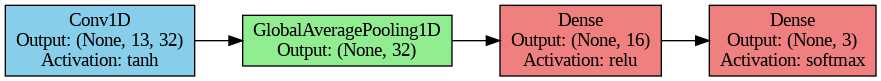

In [ ]:
from graphviz import Digraph
from IPython.display import Image, display

# Call the model on dummy input to initialize output shapes
dummy_input = tf.random.normal((1, 12, 6))
_ = model(dummy_input)

# Visualization function
def visualize_model_colab(model):
    dot = Digraph(comment="Neural Network Architecture")
    dot.attr(rankdir='LR', bgcolor='white', style='filled', color='lightgrey')

    layer_styles = {
        'Conv1D': 'skyblue',
        'GlobalAveragePooling1D': 'lightgreen',
        'Dense': 'lightcoral',
    }

    for i, layer in enumerate(model.layers):
        layer_type = layer.__class__.__name__
        output_shape = layer.output.shape
        activation = layer.get_config().get("activation", "")
        label = f"{layer_type}\nOutput: {output_shape}"
        if activation:
            label += f"\nActivation: {activation}"

        dot.node(str(i), label, shape='box', style='filled', fillcolor=layer_styles.get(layer_type, 'lightgrey'))
        if i > 0:
            dot.edge(str(i-1), str(i))

    dot.render('/tmp/model_architecture', format='png', cleanup=True)
    display(Image('/tmp/model_architecture.png'))

# Visualize
visualize_model_colab(model)


# --- Train model ---

In [ ]:
history = model.fit(X, y_cat, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6929 - loss: 0.7608 - val_accuracy: 0.9503 - val_loss: 0.3102
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9366 - loss: 0.3068 - val_accuracy: 0.9868 - val_loss: 0.1452
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9686 - loss: 0.1568 - val_accuracy: 0.9901 - val_loss: 0.0781
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9795 - loss: 0.1058 - val_accuracy: 0.9934 - val_loss: 0.0502
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9939 - loss: 0.0500 - val_accuracy: 0.9901 - val_loss: 0.0419
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9884 - loss: 0.0434 - val_accuracy: 0.9934 - val_loss: 0.0326
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 0.0270 - val_accuracy: 0.9934 - val_loss: 0.0281
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9945 - loss: 0.0215 - val_accuracy: 0.

# --- Plot training history ---

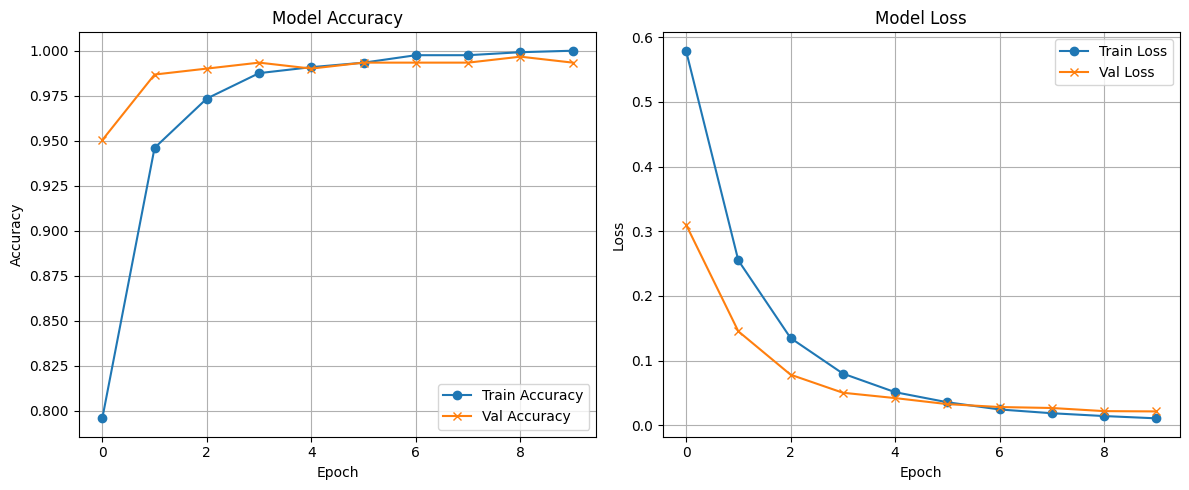

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Save model ---

In [ ]:
model.save("boxing_lstm_model.h5")


# --- Convert to TFLite (float) ---

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Optional quantization (still okay to keep)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("boxing_model_left_15.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp8boxmnao'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15, 6), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132966602630992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132966602629840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132966602630032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132966602631184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132966457573840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132966457575184: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import flatbuffers
import os
from tensorflow.lite.python import schema_py_generated as schema

# Load model
with open("boxing_model_left_15.tflite", "rb") as f:
    buf = f.read()

model = schema.Model.GetRootAsModel(buf, 0)

# TFLite BuiltinOperator enum (manually mapped for readability)
builtin_op_map = {v: k for k, v in schema.BuiltinOperator.__dict__.items() if isinstance(v, int)}

print("=== Operators in the model ===")
for i in range(model.OperatorCodesLength()):
    op_code = model.OperatorCodes(i)
    builtin_code = op_code.BuiltinCode()
    if builtin_code == schema.BuiltinOperator.CUSTOM:
        print(f"[CUSTOM] {op_code.CustomCode().decode('utf-8')}")
    else:
        op_name = builtin_op_map.get(builtin_code, f"Unknown({builtin_code})")
        print(f"[BUILTIN] {op_name}")


=== Operators in the model ===
[BUILTIN] EXPAND_DIMS
[BUILTIN] CONV_2D
[BUILTIN] TANH
[BUILTIN] RESHAPE
[BUILTIN] MEAN
[BUILTIN] FULLY_CONNECTED
[BUILTIN] SOFTMAX
